In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
####Importing the dataset####

#importing the libraries
from six.moves import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")
    
#############################

In [3]:
####Getting info on the dataset####
mnist
###################################

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
####Getting the raw data and the labels####
X, y = mnist["data"], mnist["target"]
###########################################

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

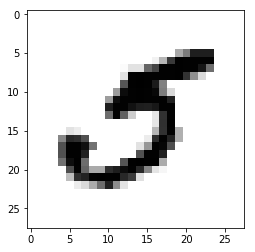

In [7]:
####Visualizing the dataset####

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

some_image = X[36000]
some_image_data = some_image.reshape(28,28)
plt.imshow(some_image_data, cmap = matplotlib.cm.binary,
           interpolation = "nearest")

###############################

In [8]:
y[36000]

5.0

In [9]:
####Splitting the dataset into training and test set####

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

########################################################

In [10]:
y_test

array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

In [11]:
####Shuffling the data in the training set####

#Importing the libraries
import numpy as np

#shuffling the data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

##############################################

In [12]:
####Training a binary classifier####

#Importing the libraries
from sklearn.linear_model import SGDClassifier

#Creating binary labels
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

#Creating the classifier binary model
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

#Testing on the random element
sgd_clf.predict([some_image])

####################################

array([ True], dtype=bool)

In [13]:
####Implementing cross validation####

#Importing the libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#Creating an object of the StatifiedKFold class
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

#Applying cross validation on the data set(training)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

#####################################

0.9667
0.9618
0.9598


In [14]:
####Using the actual cross validation class####

#Importing the libraries
from sklearn.model_selection import cross_val_score

#Getting the scores
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

###############################################

array([ 0.9667,  0.9618,  0.9598])

In [15]:
####Getting the cross validation predictions####

#Importing the libraries
from sklearn.model_selection import cross_val_predict

#Getting the predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
y_train_pred

#################################################

array([False, False, False, ..., False,  True, False], dtype=bool)

In [16]:
####Testing with confusion matrix####

#Importing the libraries
from sklearn.metrics import confusion_matrix

#Using the confusion matrix
confusion_matrix(y_train_5, y_train_pred)

#####################################

array([[53954,   625],
       [ 1609,  3812]], dtype=int64)

In [17]:
####Precision and recall####

#Importing the libraries
from sklearn.metrics import precision_score, recall_score

#Getting the precision score
precision_score(y_train_5, y_train_pred)

############################

0.85913905792201939

In [18]:
####Getting the recall score####

#Getting the sensitivity or recall score
recall_score(y_train_5, y_train_pred)

################################

0.70319129311935069

In [19]:
####Getting the F1 score####

#Importing the libraries
from sklearn.metrics import f1_score

#Calculating the score
f1_score(y_train_5, y_train_pred)

############################

0.77338202475147089

In [20]:
####Getting the prediction scores####

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                            method = "decision_function")
y_scores

#####################################

array([ -72987.35931309, -602367.306477  , -803274.07715745, ...,
       -326301.69353371,   76134.18923186, -458528.62003582])

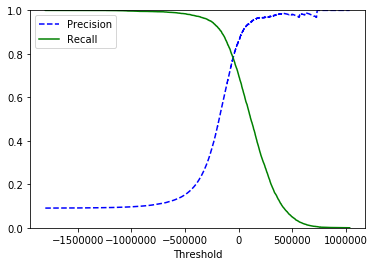

In [21]:
####Precision-Recall Graph####

#Importing the libraries
from sklearn.metrics import precision_recall_curve

#Obtaining the precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#Getting the Graph
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

##############################

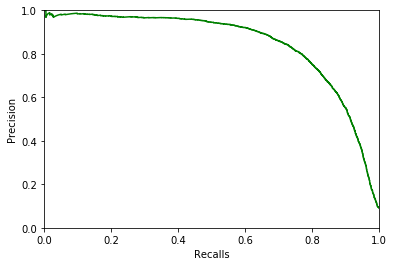

In [22]:
####Plotting precision vs recall####

#Defing the the plot function
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "g-")
    plt.xlabel("Recalls")
    plt.ylabel("Precision")
    plt.ylim([0,1])
    plt.xlim([0,1])
    
plot_precision_vs_recall(precisions, recalls)

####################################

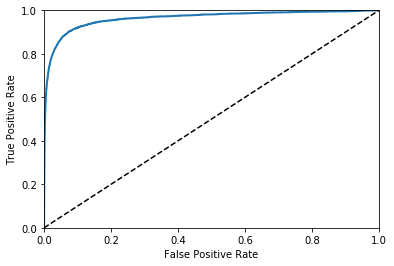

In [23]:
####Getting the ROC curve####

#Importing the libraries
from sklearn.metrics import roc_curve

#Getting the TFR and FPR against various thresholds
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#The plot function
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)

#############################

In [24]:
####Training a Random Forest Classifier####

#Importing the libraries
from sklearn.ensemble import RandomForestClassifier

#Fitting the model
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(X_train, y_train_5)

#Getting the probability scores on Random Forest Classifier
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                   method = "predict_proba")

###########################################

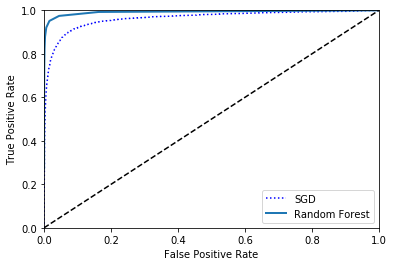

In [25]:
####Getting the TPR and FPR on Random forest####

#Getting the positive probabilities
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#Plotting the random forest TPR vs FPR
plt.plot(fpr,tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")

##################################################################

In [26]:
####Getting the ROC AUC####

#Importing the libraries
from sklearn.metrics import roc_auc_score

#For the SGD Classifier
print(roc_auc_score(y_train_5, y_scores))

#For the Random Forest Classifier
print(roc_auc_score(y_train_5, y_scores_forest))

###########################

0.963646595799
0.99231514585


In [27]:
forest_clf.predict([some_image])

array([ True], dtype=bool)

In [28]:
####Getting the Binary predictions from the Random Forest Classifier####

y_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

########################################################################

In [29]:
y_forest_pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [30]:
####Getting the precision and recall on the RFC####

precision_score(y_train_5, y_forest_pred)

recall_score(y_train_5, y_forest_pred)

###################################################

0.82254196642685851

In [31]:
####Training a OvO SGD Classifier####

#Fitting the new classifier
sgd_clf.fit(X_train, y_train)

#Testing the prediction
sgd_clf.predict([some_image])

#####################################

array([ 0.])

In [32]:
some_digit_scores = sgd_clf.decision_function([some_image])
some_digit_scores

array([[  71037.55688999, -497364.54557443, -555290.49323021,
        -309746.73588533, -479562.5318613 ,   64275.50562091,
        -804372.8832781 , -189029.71791208, -732068.0000489 ,
        -386360.43075709]])

In [33]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [34]:
####Training a multiclass Random Forest Classifier####

forest_norm_clf = RandomForestClassifier(random_state = 42)

forest_norm_clf.fit(X_train, y_train)

forest_norm_clf.predict([some_image])

######################################################

array([ 5.])

In [35]:
y_forest_norm_pred = cross_val_predict(forest_norm_clf, X_train, y_train, cv = 3)

In [36]:
y_forest_norm_pred

array([ 5.,  8.,  2., ...,  4.,  7.,  6.])

In [37]:
precision_score(y_train, y_forest_norm_pred, average = "macro")

0.93979399395583574

In [38]:
cross_val_score(forest_norm_clf, X_train, y_train, cv=3, scoring = "accuracy")

array([ 0.93841232,  0.94024701,  0.94234135])

In [39]:
y_pred_forest = forest_norm_clf.predict(X_test)

In [40]:
####Getting the accuracy on the test set####

#Importing the libraries
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_forest)

############################################

0.95040000000000002

In [41]:
####Performing grid search on Random Forest####

#Importing the libraries
from sklearn.model_selection import GridSearchCV

#Mentioning the parameters
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10,30], 'max_features': [2,4,6,8]}
]

grid_search = GridSearchCV(forest_norm_clf, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

#Fitting the model
grid_search.fit(X_train, y_train)

###############################################

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [42]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
final_model = grid_search.best_estimator_

y_pred_final = final_model.predict(X_test)

In [44]:
accuracy_score(y_test, y_pred_final)

0.96160000000000001

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [46]:
y_pred_knn = knn_clf.predict(X_test)

accuracy_score(y_test, y_pred_knn)

0.96879999999999999

In [47]:
from sklearn.svm import SVC

svc_clf = SVC(C=5, gamma=0.05)

In [ ]:
from scipy import sparse

X_train_sparse = sparse.csr_matrix(X_train)
#y_train_sparse = sparse.csr_matrix(y_train)

svc_clf.fit(X_train_sparse, y_train)